In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Read in training and testing datasets
train = pd.read_excel("apple_train_data_final.xlsx")
test = pd.read_excel("apple_test_data_final.xlsx")


In [6]:
# merge the two dataframes
train['train'] = 1
test['train'] = 0
iphone_data = pd.concat([train, test], axis=0).drop('phone model', axis=1)

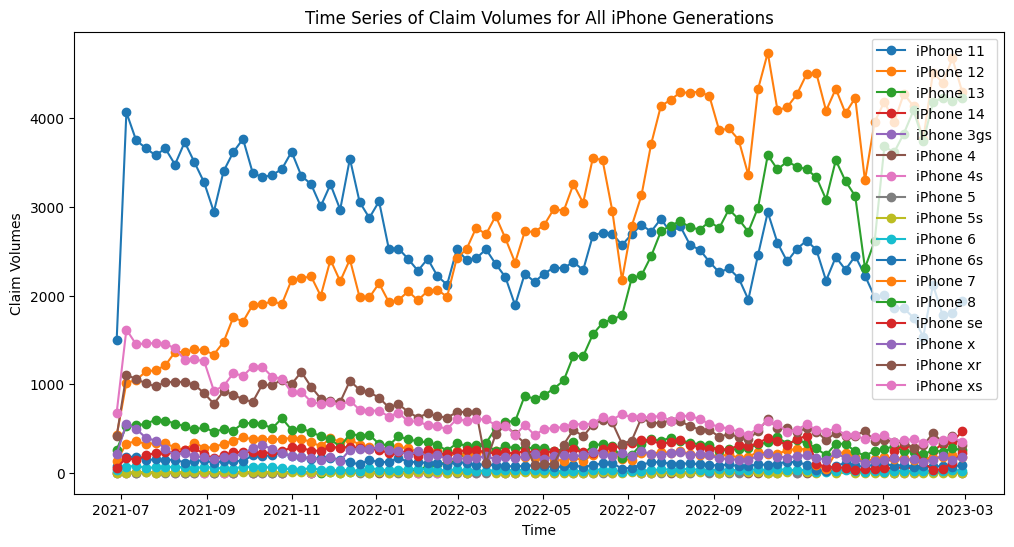

In [8]:
# No need to filter for specific generations, so we can use the original data
all_iphones = iphone_data[['claim', 'weeks_since_release', 'weeks_monday', 'generation']]

# Group by weeks_monday and generation, sum up all the claims
grouped_data = all_iphones.groupby(['weeks_monday', 'generation']).agg({'claim': 'sum'}).reset_index()

# Pivot the table to have generations as columns
pivot_data = grouped_data.pivot_table(index='weeks_monday', columns='generation', values='claim', fill_value=0).reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for gen in pivot_data.columns[1:]:
    # Filter out rows with zero claims
    filtered_data = pivot_data[pivot_data[gen] > 0]
    
    plt.plot(filtered_data['weeks_monday'], filtered_data[gen], label=f"iPhone {gen}", marker='o')

plt.xlabel("Time")
plt.ylabel("Claim Volumes")
plt.title("Time Series of Claim Volumes for All iPhone Generations")
plt.legend()
plt.show()


In [10]:
train.head()

,phone model,phone size,phone color,claim,weeks_monday,generation,week_of_month,month,year,weeks_since_release,is_holiday,day,train
0,apple iphone 11,128,black,111,2021-06-28,11,4,6,2021,92.428571,1,28,1
1,apple iphone 11,128,black,319,2021-07-05,11,1,7,2021,93.428571,1,5,1
2,apple iphone 11,128,black,320,2021-07-12,11,2,7,2021,94.428571,1,12,1
3,apple iphone 11,128,black,305,2021-07-19,11,3,7,2021,95.428571,1,19,1
4,apple iphone 11,128,black,269,2021-07-26,11,4,7,2021,96.428571,1,26,1


In [57]:
# Get the unique values in the 'generation' column
generations = train['generation'].unique()

# Create a list of unique generations
unique_generations_train = list(generations)

# Print the list of unique generations
print("List of unique generations in the train dataset:", unique_generations_train)

List of unique generations in the train dataset: ['11', '12', '13', '14', '3gs', '4', '4s', '5', '5s', '6', '6s', '7', '8', 'se', 'x', 'xr', 'xs']


To handle categorical data for generations, we can use one-hot encoding for the generation feature

In [58]:
# Get the unique values in the 'generation' column
generations = test['generation'].unique()

# Create a list of unique generations
unique_generations_test = list(generations)

# Print the list of unique generations
print("List of unique generations in the train dataset:", unique_generations_test)


List of unique generations in the train dataset: ['14']


Since we are essentially predict the total weekly claims for iPhone 14. We can filter out all the other generations in the testing dataset.

In [35]:
test = test[test['generation'] == '14']

In [36]:
#Check
generations_test = test['generation'].unique()
# Print the list of unique generations
print("List of unique generations in the train dataset:")
for generation in generations_test:
    print(generation)

List of unique generations in the train dataset:
14


# Long short-term memory: a type of recurrent neural network (RNN)

This code uses only the features 'generation', 'week_of_month', 'month', 'year', 'weeks_since_release', 'day' for the X_train and X_test datasets, and the claim feature for the y_train and y_test datasets. I simply use the original train and test datasets without aggregation. The train and test datasets are scaled separately, and the test dataset is not seen during the training process.

I also create a separate OneHotEncoder for the 'generation' feature and modify the scaling and encoding process

In [37]:
from sklearn.preprocessing import OneHotEncoder

In [38]:
# Separate 'generation' feature from other numerical input features
numerical_input_features = ['week_of_month', 'month', 'year', 'weeks_since_release', 'day']
categorical_input_features = ['generation']
output_feature = 'claim'


# Scale numerical input features
scaler_x_numerical = MinMaxScaler()
scaled_train_x_numerical = scaler_x_numerical.fit_transform(train[numerical_input_features])
scaled_test_x_numerical = scaler_x_numerical.transform(test[numerical_input_features])

# One-hot encode the categorical 'generation' feature
encoder_x_categorical = OneHotEncoder()
scaled_train_x_categorical = encoder_x_categorical.fit_transform(train[categorical_input_features]).toarray()
scaled_test_x_categorical = encoder_x_categorical.transform(test[categorical_input_features]).toarray()

# Concatenate the scaled numerical input features and one-hot encoded categorical input features
scaled_train_x = np.hstack([scaled_train_x_numerical, scaled_train_x_categorical])
scaled_test_x = np.hstack([scaled_test_x_numerical, scaled_test_x_categorical])

# Scale output feature
scaler_y = MinMaxScaler()
scaled_train_y = scaler_y.fit_transform(train[[output_feature]])
scaled_test_y = scaler_y.transform(test[[output_feature]])

window_size = 5
def sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size, :-1].values)
        y.append(data.iloc[i + window_size, -1])  # Claim is the target variable
    return np.array(X), np.array(y)


In [40]:
# Create sliding window sequences for the train and test datasets
train_data = pd.DataFrame(np.hstack([scaled_train_x, scaled_train_y]), columns=numerical_input_features + encoder_x_categorical.get_feature_names_out(categorical_input_features).tolist() + [output_feature])
test_data = pd.DataFrame(np.hstack([scaled_test_x, scaled_test_y]), columns=numerical_input_features + encoder_x_categorical.get_feature_names_out(categorical_input_features).tolist() + [output_feature])

X_train, y_train = sliding_window(train_data, window_size)
X_test, y_test = sliding_window(test_data, window_size)

from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build a more complex LSTM model
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(25, activation='tanh'),
    Dense(1)
])

# Use a custom learning rate for the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Train the model for more epochs
model.fit(X_train, y_train, epochs=10, verbose=1)

# Evaluate the model on the test data
y_pred = model.predict(X_test)


Epoch 1/10
496/496 [==============================] - 16s 19ms/step - loss: 0.0110
Epoch 2/10
496/496 [==============================] - 9s 19ms/step - loss: 0.0109
Epoch 3/10
496/496 [==============================] - 8s 15ms/step - loss: 0.0108
Epoch 4/10
496/496 [==============================] - 9s 19ms/step - loss: 0.0108
Epoch 5/10
496/496 [==============================] - 14s 27ms/step - loss: 0.0108
Epoch 6/10
496/496 [==============================] - 15s 31ms/step - loss: 0.0108
Epoch 7/10
496/496 [==============================] - 13s 27ms/step - loss: 0.0108
Epoch 8/10
496/496 [==============================] - 13s 27ms/step - loss: 0.0107
Epoch 9/10
496/496 [==============================] - 11s 22ms/step - loss: 0.0107
Epoch 10/10
3/3 [==============================] - 1s 6ms/step


In [46]:
#print(y_pred)

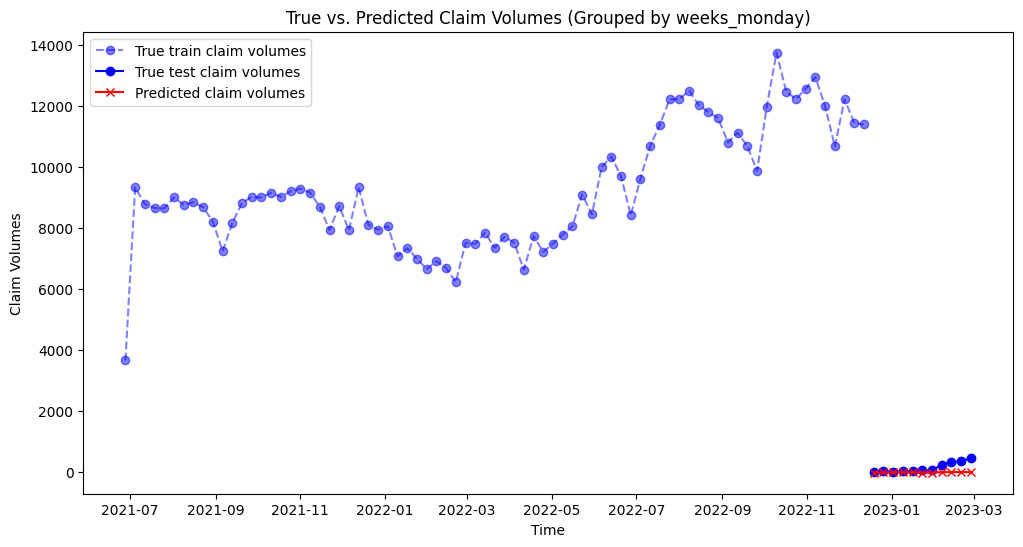

In [42]:
# Inverse transform the claim values
# Inverse transform the claim values
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred).flatten()


# Group the true train, true test, and predicted claim volumes by weeks_monday
train_grouped = train.iloc[window_size:].copy()
train_grouped['claim'] = y_train_inv
train_grouped = train_grouped.groupby('weeks_monday')['claim'].sum().reset_index()

test_grouped = test.iloc[window_size:].copy()
test_grouped['claim'] = y_test_inv
test_grouped = test_grouped.groupby('weeks_monday')['claim'].sum().reset_index()

pred_grouped = test.iloc[window_size:].copy()
pred_grouped['predicted_claim'] = y_pred_inv
pred_grouped = pred_grouped.groupby('weeks_monday')['predicted_claim'].sum().reset_index()

# Convert numeric dates back to Timestamps
train_dates_grouped = pd.to_datetime(train_grouped['weeks_monday'].values, unit='D')
test_dates_grouped = pd.to_datetime(test_grouped['weeks_monday'].values, unit='D')
pred_dates_grouped = pd.to_datetime(pred_grouped['weeks_monday'].values, unit='D')

# Plot true vs. predicted claim volumes
plt.figure(figsize=(12, 6))
plt.plot(train_dates_grouped, train_grouped['claim'], label="True train claim volumes", marker='o', linestyle='--', color='blue', alpha=0.5)
plt.plot(test_dates_grouped, test_grouped['claim'], label="True test claim volumes", marker='o', color='blue')
plt.plot(pred_dates_grouped, pred_grouped['predicted_claim'], label="Predicted claim volumes", marker='x', color='red')
plt.xlabel("Time")
plt.ylabel("Claim Volumes")

plt.title("True vs. Predicted Claim Volumes (Grouped by weeks_monday)")
plt.legend()
plt.show()

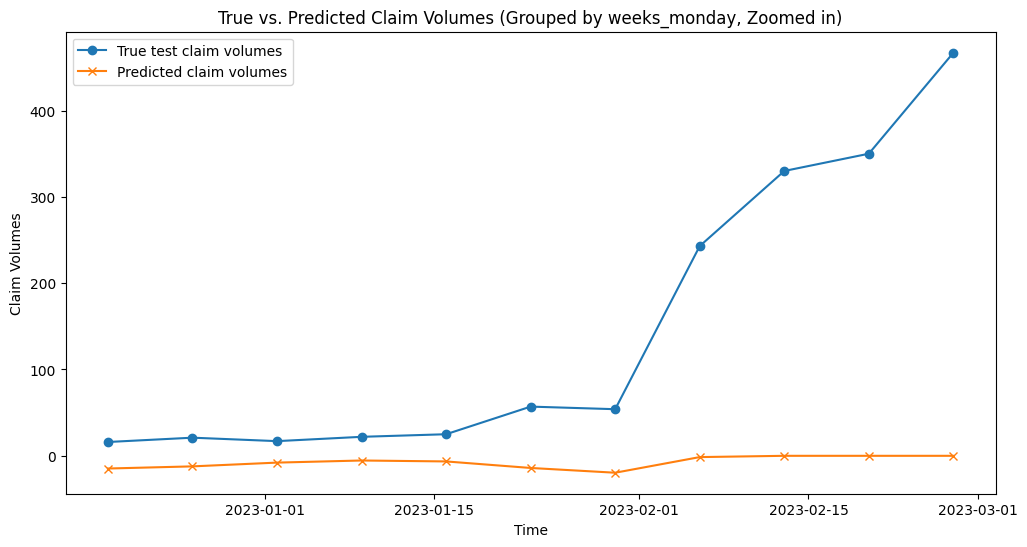

In [44]:
# Plot true vs. predicted claim volumes (zoomed-in)
plt.figure(figsize=(12, 6))
plt.plot(test_dates_grouped[-20:], test_grouped['claim'][-20:], label="True test claim volumes", marker='o')  # Show only the last 20 data points
plt.plot(pred_dates_grouped[-20:], pred_grouped['predicted_claim'][-20:], label="Predicted claim volumes", marker='x')  # Show only the last 20 data points
plt.xlabel("Time")
plt.ylabel("Claim Volumes")
plt.title("True vs. Predicted Claim Volumes (Grouped by weeks_monday, Zoomed in)")
plt.legend()
plt.show()

In [45]:
def wmape(actual, forecast):
    """Calculate Weighted Mean Absolute Percentage Error (WMAPE) with equal weights"""

    numerator = np.sum(np.abs(actual - forecast)) * 100
    denominator = np.sum(np.abs(actual))

    return numerator/denominator

# Calculate WMAPE
WMAPE_score = wmape(test_grouped['claim'].values, pred_grouped['predicted_claim'].values)
print(f'WMAPE score: {WMAPE_score:.2f}%')

WMAPE score: 105.12%


Based on the WMAPE score of 105.12% for the total claim volumes without considering the storage size, the model's predictions for the iPhone 14 are not very accurate. This result indicates that, on average, the model's predictions deviate from the actual claim volumes by 105.12%.

# Besides, we also would like to predict the iPhone 14 claims with different storage sizes.

To include the "phone size" as both an input and output feature, I'll need to modify your code as follows:

*   Add the "phone size" feature to the list of categorical input features.
*   One-hot encode the "phone size" feature and concatenate it with the other input features.  
*   Modify the output feature to include both "claim" and "phone size".  
*   Update the sliding window function to handle multiple output features.
*   Modify the LSTM model to predict multiple output features.  
*   Adjust the evaluation and plotting code to handle the new output features.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential

# Modify input and output features
numerical_input_features = ['week_of_month', 'month', 'year', 'weeks_since_release', 'day']
categorical_input_features = ['generation', 'phone size']
output_features = ['claim', 'phone size']

# Scale numerical input features
scaler_x_numerical = MinMaxScaler()
scaled_train_x_numerical = scaler_x_numerical.fit_transform(train[numerical_input_features])
scaled_test_x_numerical = scaler_x_numerical.transform(test[numerical_input_features])

# One-hot encode the categorical input features
encoder_x_categorical = OneHotEncoder()
scaled_train_x_categorical = encoder_x_categorical.fit_transform(train[categorical_input_features]).toarray()
scaled_test_x_categorical = encoder_x_categorical.transform(test[categorical_input_features]).toarray()

# Concatenate the scaled numerical input features and one-hot encoded categorical input features
scaled_train_x = np.hstack([scaled_train_x_numerical, scaled_train_x_categorical])
scaled_test_x = np.hstack([scaled_test_x_numerical, scaled_test_x_categorical])

# Scale output features
scaler_y = MinMaxScaler()
scaled_train_y = scaler_y.fit_transform(train[output_features])
scaled_test_y = scaler_y.transform(test[output_features])

window_size = 5

# Modify the sliding window function for multiple output features
def sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:i + window_size, :-len(output_features)].values)
        y.append(data.iloc[i + window_size, -len(output_features):].values)  # Claim and phone size are the target variables
    return np.array(X), np.array(y)

# Create sliding window sequences for the train and test datasets
train_data = pd.DataFrame(np.hstack([scaled_train_x, scaled_train_y]), columns=numerical_input_features + encoder_x_categorical.get_feature_names_out(categorical_input_features).tolist() + output_features)
test_data = pd.DataFrame(np.hstack([scaled_test_x, scaled_test_y]), columns=numerical_input_features + encoder_x_categorical.get_feature_names_out(categorical_input_features).tolist() + output_features)

X_train, y_train = sliding_window(train_data, window_size)
X_test, y_test = sliding_window(test_data, window_size)

# Modify the LSTM model to predict multiple output features
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(25, activation='tanh'),
    Dense(len(output_features))
])

# Use a custom learning rate for the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


# Use a custom learning rate for the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Train the model for more epochs
model.fit(X_train, y_train, epochs=10, verbose=1)

# Evaluate the model on the test data
y_pred = model.predict(X_test)


Epoch 1/10
496/496 [==============================] - 33s 18ms/step - loss: 0.0078
Epoch 2/10
496/496 [==============================] - 8s 16ms/step - loss: 0.0061
Epoch 3/10
496/496 [==============================] - 9s 19ms/step - loss: 0.0059
Epoch 4/10
496/496 [==============================] - 8s 16ms/step - loss: 0.0057
Epoch 5/10
496/496 [==============================] - 10s 21ms/step - loss: 0.0056
Epoch 6/10
496/496 [==============================] - 9s 18ms/step - loss: 0.0055
Epoch 7/10
496/496 [==============================] - 8s 16ms/step - loss: 0.0054
Epoch 8/10
496/496 [==============================] - 9s 19ms/step - loss: 0.0053
Epoch 9/10
496/496 [==============================] - 8s 16ms/step - loss: 0.0053
Epoch 10/10
496/496 [==============================] - 11s 23ms/step - loss: 0.0053


I will group the data by both 'weeks_monday' and 'phone_size', and then plot a line for each storage size.

In [56]:
def wmape(actual, forecast):
    """Calculate Weighted Mean Absolute Percentage Error (WMAPE) with equal weights"""
    numerator = np.sum(np.abs(actual - forecast)) * 100
    denominator = np.sum(np.abs(actual))
    return numerator / denominator

phone_sizes = test['phone size'].unique()
# Calculate WMAPE for each phone size
for size in phone_sizes:
    test_grouped_size = test_grouped[test_grouped['phone size'] == size]
    pred_grouped_size = pred_grouped[pred_grouped['phone size'] == size]

    WMAPE_score = wmape(test_grouped_size[output_feature].values, pred_grouped_size['predicted_claim'].values)
    print(f'WMAPE score for phone size {size}: {WMAPE_score:.2f}%')


WMAPE score for phone size 128: 105.79%
WMAPE score for phone size 256: 224.19%
WMAPE score for phone size 512: 968.54%


128 GB (WMAPE: 105.79%): For the 128 GB storage size, the model's predictions have an average percentage error of 105.79%. This indicates that the model is not very accurate in predicting the claim volumes for iPhone 14 with 128 GB storage. The error could be attributed to various factors such as insufficient data, high variance in the data, or an inadequate model architecture.

256 GB (WMAPE: 224.19%): The WMAPE score for the 256 GB storage size is even higher, at 224.19%. This suggests that the model's predictions for the iPhone 14 with 256 GB storage are even less accurate than for the 128 GB variant. The reasons for the higher error could be similar to those for the 128 GB variant, or there could be additional factors at play, such as a more diverse customer base or more complex claim patterns for this storage size.

512 GB (WMAPE: 968.54%): The WMAPE score for the 512 GB storage size is alarmingly high, at 968.54%. This result implies that the model's predictions for the iPhone 14 with 512 GB storage are far from accurate. One possible explanation for this high error rate is the lack of data for iPhone 14 with 512 GB storage in February. Insufficient data makes it difficult for the model to capture the claim patterns accurately. Other factors that could contribute to the high error rate include data anomalies, significant variability in the claim volumes, or the model not being well-suited for this specific storage size.